In [1]:
from typing import Union
from os.path import basename
from dateutil import parser
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from rasters import Raster
from time_conversion import calculate_hour_of_day
from STIC_sensitivity import process_STIC_table
from PTJPL_sensitivity import process_PTJPL_table
from PTJPL.Topt import load_Topt
from PTJPL.fAPARmax import load_fAPARmax
from SEBAL import process_SEBAL_G_table
from harmonized_landsat_sentinel import HLS2SentinelGranule
from sensitivity import perturbed_run, joint_perturbed_run, repeat_rows
from evapotranspiration_conversion import process_daily_ET_table
from mpl_toolkits.mplot3d import Axes3D
from verma_net_radiation_sensitivity.verma_net_radiation_sensitivity import process_verma_net_radiation_table
from evapotranspiration_conversion import process_daily_ET_table

%matplotlib inline

In [2]:
ST_C_filename = "ECOSTRESS_example_rasters/ECOv002_L2T_LSTE_21485_013_11SPS_20220420T211350_0601_01_LST.tif"
ST_C = Raster.open(ST_C_filename) - 273.15
# ST_C

[2024-12-19 12:34:02 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:02 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:34:02 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:02 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [3]:
geometry = ST_C.geometry
# geometry

In [4]:
time_UTC = parser.parse(basename(ST_C_filename).split("_")[6])
# time_UTC

In [5]:
doy = time_UTC.timetuple().tm_yday
# doy

In [6]:
hour_of_day = calculate_hour_of_day(time_UTC, geometry=geometry)
# hour_of_day

In [7]:
emissivity_filename = "../ET-Sensitivity-internal/example_ECOSTRESS_input/ECOv002_L2T_LSTE_21485_013_11SPS_20220420T211350_0601_01/ECOv002_L2T_LSTE_21485_013_11SPS_20220420T211350_0601_01_EmisWB.tif"
emissivity = Raster.open(emissivity_filename)
# emissivity

[2024-12-19 12:34:03 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:03 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:34:03 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:03 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [8]:
sentinel = HLS2SentinelGranule("../ET-Sensitivity-internal/example_ECOSTRESS_input/HLS.S30.T11SPS.2022110T181909.v2.0")
# sentinel

In [9]:
NIR = sentinel.NIR.to_geometry(geometry)
# NIR

In [10]:
red = sentinel.red.to_geometry(geometry)
# red

In [11]:
albedo_filename = "ECOSTRESS_example_rasters/ECOv002_L2T_STARS_21485_013_11SPS_20220420_0700_01_albedo.tif"
albedo = Raster.open(albedo_filename)
# albedo

[2024-12-19 12:34:06 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:06 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [12]:
Ta_C_filename = "ECOSTRESS_example_rasters/ECOv002_L3T_MET_21485_013_11SPS_20220420T211350_0700_01_Ta.tif"
Ta_C = Raster.open(Ta_C_filename)
# Ta_C

[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [13]:
RH_filename = "ECOSTRESS_example_rasters/ECOv002_L3T_MET_21485_013_11SPS_20220420T211350_0700_01_RH.tif"
RH = Raster.open(RH_filename)
# RH

[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [14]:
Rn_filename = "ECOSTRESS_example_rasters/ECOv002_L3T_SEB_21485_013_11SPS_20220420T211350_0700_01_Rn.tif"
Rn = Raster.open(Rn_filename)
# Rn

[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:07 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:34:08 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:08 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [15]:
Rg_filename = "../ET-Sensitivity-internal/example_ECOSTRESS_input/ECOv002_L3T_SEB_21485_013_11SPS_20220420T211350_0700_01/ECOv002_L3T_SEB_21485_013_11SPS_20220420T211350_0700_01_Rg.tif"
Rg = Raster.open(Rg_filename)
# Rg

[2024-12-19 12:34:08 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:08 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:32611 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
[2024-12-19 12:34:08 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:08 WARNING] CPLE_AppDefined in The definition of projected CRS EPSG:3

In [16]:
Topt = load_Topt(geometry)
# Topt

[2024-12-19 12:34:08 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:08 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [17]:
fAPARmax = load_fAPARmax(geometry)
# fAPARmax

[2024-12-19 12:34:09 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
[2024-12-19 12:34:09 WARNING] CPLE_AppDefined in PROJ: proj_create_from_database: /Users/Maggiej/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


In [18]:
def reflectance_to_NDVI(NIR: Union[Raster, np.ndarray], red: Union[Raster, np.ndarray]) -> Union[Raster, np.ndarray]:
    return (NIR - red) / (NIR + red)

def reflectance_to_NDVI_table(input_df: pd.DataFrame) -> pd.DataFrame:
    NIR = input_df["NIR"]
    red = input_df["red"]
    NDVI = reflectance_to_NDVI(NIR, red)
    output_df = input_df.copy()
    output_df["NDVI"] = NDVI

    return output_df

def process_verma_PTJPL_table(input_df: pd.DataFrame) -> pd.DataFrame:
    return process_PTJPL_table(process_verma_net_radiation_table(reflectance_to_NDVI_table(input_df)))


In [19]:
input_df = pd.DataFrame({
    "hour_of_day": hour_of_day.flatten(),
    "lat": geometry.lat.flatten(),
    "lon": geometry.lon.flatten(),
    "NIR": NIR.flatten(),
    "red": red.flatten(),
    "ST_C": ST_C.flatten(),
    "EmisWB": emissivity.flatten(),
    "albedo": albedo.flatten(),
    "Ta_C": Ta_C.flatten(),
    "RH": RH.flatten(),
    "Rn": Rn.flatten(),
    "Rg": Rg.flatten(),
    "Topt": Topt.flatten(),
    "fAPARmax": fAPARmax.flatten()
})

input_df["doy"] = doy

input_df = input_df.dropna()
sample_df = input_df.sample(1000)
sample_df

,hour_of_day,lat,lon,NIR,red,ST_C,EmisWB,albedo,Ta_C,RH,Rn,Rg,Topt,fAPARmax,doy
2371601,13.540507,32.473731,-115.350732,0.2741,0.2131,47.290009,0.958,0.149902,32.674305,0.349492,463.043610,736.248840,17.69,0.2972,110
1082271,13.519474,32.996465,-115.666228,0.3440,0.1323,42.770020,0.976,0.139162,33.574917,0.348259,472.226868,697.629700,16.39,0.3078,110
2087610,13.531550,32.589700,-115.485090,0.3213,0.2713,46.230011,0.974,0.168053,32.305740,0.353677,432.380341,723.224121,16.70,0.2569,110
1778949,13.543387,32.711808,-115.307532,0.5198,0.0374,39.750000,0.938,0.144787,34.824738,0.344665,529.450867,713.826050,17.68,0.3836,110
1476341,13.544338,32.833462,-115.293262,0.3837,0.0556,36.630005,0.956,0.122404,33.957039,0.349156,541.057739,704.521851,18.48,0.3282,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006491,13.572047,33.016479,-114.877626,0.2419,0.2136,46.790009,0.930,0.147275,30.790352,0.350274,448.784576,712.460388,17.84,0.1885,110
2022269,13.557184,32.610989,-115.100572,0.2394,0.1694,42.910004,0.960,0.121584,32.271267,0.352341,488.205170,711.048157,25.61,0.2902,110
1745114,13.576303,32.718058,-114.813785,0.4180,0.3500,49.890015,0.880,0.237396,31.385126,0.351042,381.687286,689.093384,22.36,0.1956,110
1564632,13.568353,32.792678,-114.933036,0.4696,0.3943,51.410004,0.860,0.262193,31.267498,0.350805,346.889252,670.896667,22.68,0.1861,110


In [20]:
input_variable = ["ST_C", "red", "NIR", "albedo", "Ta_C", "RH", "EmisWB", "Rg"]
input_uncertainty = np.array([1.0, 0.03, 0.03, 0.01, 2.67, 0.15, 0.02, 50])

## LST uncert is requirement
## NDVI uncert is conservative estimate from 0.03 err VNIR camera simulations (NIR and Red to NDVI Sensitivity.ipynb)
## abledo is made up as 10% error on average albedo value
## Ta_C is RMSE from Zoe cal-val
## RH is RMSE from Zoe cal-val
## Emissivity is placeholder
## Rg should get from Zoe cal-val, but only have low Rg values in this dataset... much lower than Rg RMSE
## Currently uncorrelated uncertainties (could correlated based on empirical correlation of variables)


output_variable = ["LE"]

unperturbed_input, perturbed_input_df, perturbed_output_df, results = joint_perturbed_run(
    input_df=sample_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_PTJPL_table,
    n=100,
    perturbation_mean=np.zeros(8),
    perturbation_cov=np.eye(8) * input_uncertainty ** 2,
    dropna=False
)

kp = (perturbed_input_df.NIR >= 0) & (perturbed_input_df.NIR <= 1) & (perturbed_input_df.red >= 0) & (perturbed_input_df.red <= 1)
ids = results["id"][kp & (perturbed_output_df["LE"] != 0)]

## estimate true LE
repeat_input_df = repeat_rows(sample_df,100)
repeat_input_df = repeat_input_df[kp & (perturbed_output_df["LE"] != 0)]

true_df = process_verma_PTJPL_table(repeat_input_df)
true_df["id"] = ids

perturbed_input_df = perturbed_input_df[kp & (perturbed_output_df["LE"] != 0)]
perturbed_output_df = perturbed_output_df[kp & (perturbed_output_df["LE"] != 0)]

### Process perturbed LE
perturbed_output_df["id"] = ids
perturbed_output_df["LE_perturbation"] = perturbed_output_df["LE"] - true_df["LE"]

## Process perturbed ET assuming true NDVI
perturbed_input_df['doy'] = perturbed_input_df['doy'].astype(float) 
perturbed_input_df['lat'] = perturbed_input_df['lat'].astype(float) 
perturbed_input_df['hour_of_day'] = perturbed_input_df['hour_of_day'].astype(float) 
perturbed_input_df["red"] = repeat_input_df.red
perturbed_input_df["NIR"] = repeat_input_df.NIR
perturbed_output_df_NDVI = process_verma_PTJPL_table(perturbed_input_df)
perturbed_output_df_NDVI["id"] = ids
perturbed_output_df_NDVI["LE_perturbation"] = perturbed_output_df_NDVI["LE"] - true_df["LE"]

0


/Users/Maggiej/Documents/GitHub/ET-Sensitivity/verma_net_radiation/verma_net_radiation.py:44: RuntimeWarning: invalid value encountered in sqrt
  eta2 = -(1.2 + 3 * eta1) ** 0.5
/Users/Maggiej/Documents/GitHub/ET-Sensitivity/vegetation_conversion/vegetation_conversion.py:45: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)
/Users/Maggiej/Documents/GitHub/ET-Sensitivity/verma_net_radiation/verma_net_radiation.py:44: RuntimeWarning: invalid value encountered in sqrt
  eta2 = -(1.2 + 3 * eta1) ** 0.5


In [21]:
sample_df_big = input_df.sample(50000)
sample_df_big[input_variable].corr()

,ST_C,red,NIR,albedo,Ta_C,RH,EmisWB,Rg
ST_C,1.000000,0.699991,-0.038436,0.548804,-0.211760,-0.359198,-0.515734,-0.241152
red,0.699991,1.000000,0.268472,0.907120,-0.456131,0.141275,-0.580664,-0.397757
NIR,-0.038436,0.268472,1.000000,0.617829,0.322264,-0.117685,-0.279678,-0.346974
albedo,0.548804,0.907120,0.617829,1.000000,-0.257513,0.081832,-0.589242,-0.463100
Ta_C,-0.211760,-0.456131,0.322264,-0.257513,1.000000,-0.675863,0.161911,-0.222599
RH,-0.359198,0.141275,-0.117685,0.081832,-0.675863,1.000000,0.136161,0.256509
EmisWB,-0.515734,-0.580664,-0.279678,-0.589242,0.161911,0.136161,1.000000,0.496400
Rg,-0.241152,-0.397757,-0.346974,-0.463100,-0.222599,0.256509,0.496400,1.000000


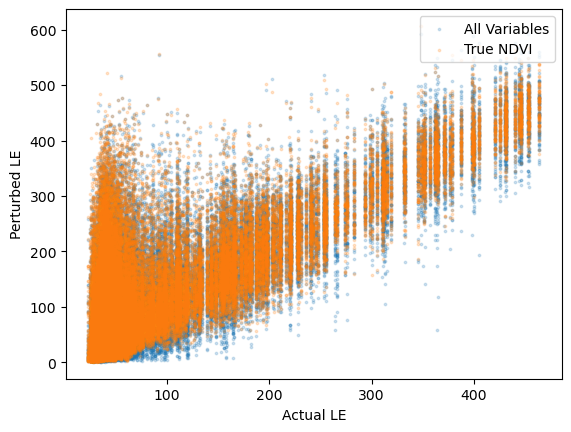

In [22]:
plt.scatter(x=true_df.LE, y=perturbed_output_df.LE,label="All Variables", alpha=0.2, s=3)
plt.scatter(x=true_df.LE, y=perturbed_output_df_NDVI.LE,label="True NDVI", alpha=0.2, s=3)
plt.xlabel("Actual LE")
plt.ylabel("Perturbed LE")
plt.legend(loc='upper right')

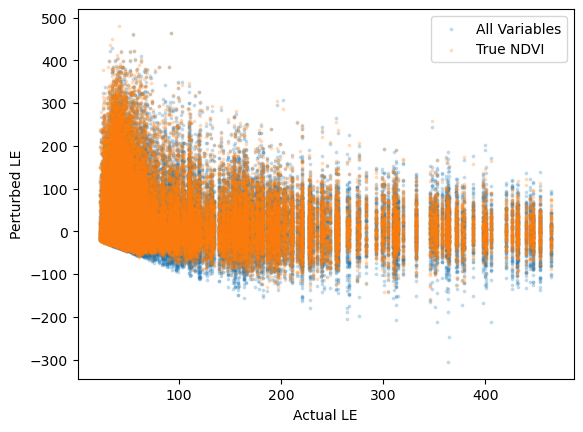

In [23]:
plt.scatter(x=true_df.LE, y=perturbed_output_df.LE_perturbation,label="All Variables", alpha=0.2, s=3)
plt.scatter(x=true_df.LE, y=perturbed_output_df_NDVI.LE_perturbation,label="True NDVI", alpha=0.2, s=3)
plt.xlabel("Actual LE")
plt.ylabel("Perturbed LE")
plt.legend(loc='upper right')

(0.0, 1.0)

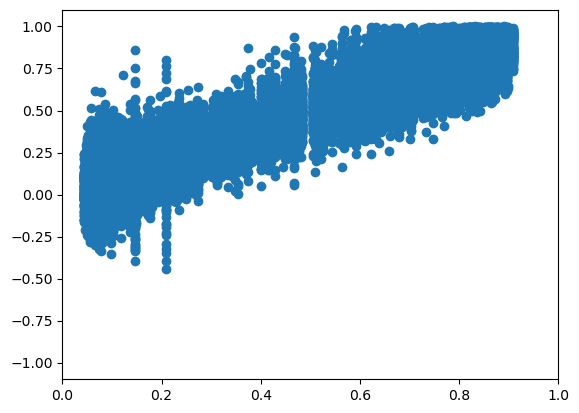

In [24]:
perturbed_NDVI = (perturbed_output_df.NIR - perturbed_output_df.red)/(perturbed_output_df.NIR + perturbed_output_df.red)
true_NDVI = (repeat_input_df.NIR - repeat_input_df.red)/(repeat_input_df.NIR + repeat_input_df.red)
plt.scatter(true_NDVI, perturbed_NDVI)
plt.xlim((0,1))

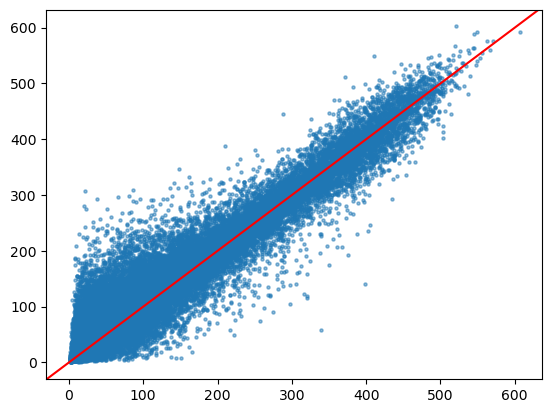

In [25]:
plt.scatter(x=perturbed_output_df_NDVI.LE, y=perturbed_output_df.LE, s=5, alpha=0.5)
plt.axline((0, 0), slope=1, c="red")
# plt.hist(true_df.ET,alpha=0.5)

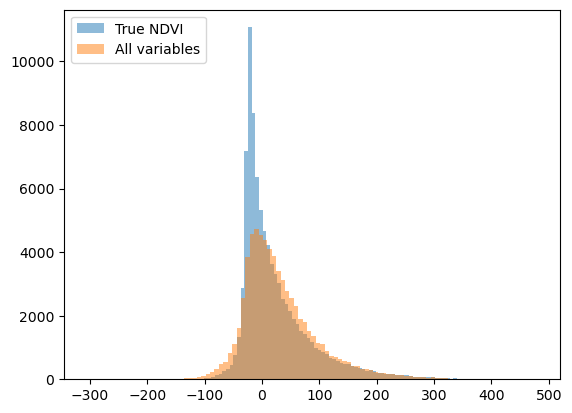

In [26]:
plt.hist(perturbed_output_df_NDVI.LE_perturbation, alpha=0.5,bins=100, label="True NDVI")
plt.hist(perturbed_output_df.LE_perturbation, alpha=0.5,bins=100, label="All variables")

plt.legend(loc='upper left')

In [27]:
results_list = [y for x, y in perturbed_output_df.groupby('id')]
results_ndvi_true_list = [y for x, y in perturbed_output_df_NDVI.groupby('id')]

sd_vars = [np.sqrt(np.nanmean(y.LE_perturbation**2,axis=0)) for y in results_list]
le_vars = [np.nanmean(y.LE,axis=0) for x,y in true_df.groupby('id')]

sd_true_vars = [np.sqrt(np.nanmean(y.LE_perturbation**2,axis=0)) for y in results_ndvi_true_list]

prop_var = np.divide(np.array(sd_true_vars)**2, np.array(sd_vars)**2)

/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_66896/3378359377.py:4: RuntimeWarning: Mean of empty slice
  sd_vars = [np.sqrt(np.nanmean(y.LE_perturbation**2,axis=0)) for y in results_list]
/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_66896/3378359377.py:5: RuntimeWarning: Mean of empty slice
  le_vars = [np.nanmean(y.LE,axis=0) for x,y in true_df.groupby('id')]
/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_66896/3378359377.py:7: RuntimeWarning: Mean of empty slice
  sd_true_vars = [np.sqrt(np.nanmean(y.LE_perturbation**2,axis=0)) for y in results_ndvi_true_list]


Text(0, 0.5, 'Total LE RMSE (mm/day)')

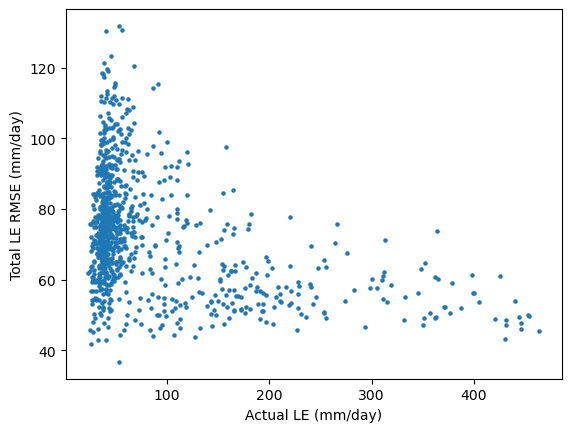

In [28]:
plt.scatter(x=le_vars, y=sd_vars,s=5)
plt.xlabel("Actual LE (mm/day)")
plt.ylabel("Total LE RMSE (mm/day)")

In [29]:
np.sqrt(np.nanmean(perturbed_output_df.LE_perturbation**2,axis=0)) ## overall rmse

73.10203556817225

In [30]:
np.sqrt(np.nanmean(perturbed_output_df.LE_perturbation**2,axis=0)) / 28.94 ## high ET error with the quick and dirty conversion

2.5259860251614463

In [31]:
np.sqrt(np.nanmean(perturbed_output_df_NDVI.LE_perturbation**2,axis=0)) ## overall rmse true NDVI

67.00342936941948

In [32]:
np.nanmean(perturbed_output_df_NDVI.LE_perturbation**2,axis=0)/np.nanmean(perturbed_output_df.LE_perturbation**2,axis=0)

0.8401080033130922

ValueError: 'RMSE right' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

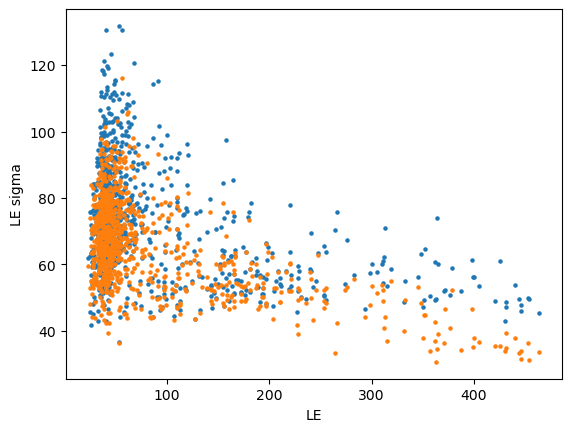

In [33]:
plt.scatter(x=le_vars, y=np.array(sd_vars),s=5, label="all variables")
plt.scatter(x=le_vars, y=np.array(sd_true_vars), s=5, label="true NDVI")
plt.xlabel("LE")
plt.ylabel("LE sigma")
plt.legend(loc='RMSE right')

Text(0, 0.5, 'Prop RSS due to NDVI error')

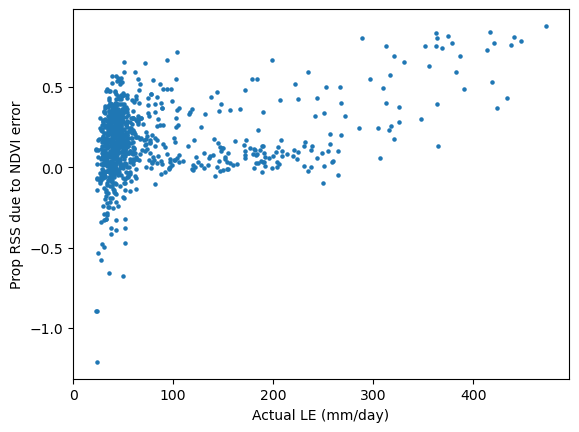

In [ ]:
plt.scatter(x=le_vars, y= 1 - prop_var,s=5)
plt.xlabel("Actual LE (mm/day)")
plt.ylabel("Prop RSS due to NDVI error") ## negatives are artifacts of all variable errors larger than true ndvi

/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_14237/577054446.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.scatter(x=le_vars, y=np.sqrt(np.array(sd_vars)**2 - np.array(sd_true_vars)**2),s=5)


Text(0, 0.5, 'LE RMSE due to NDVI (mm/day)')

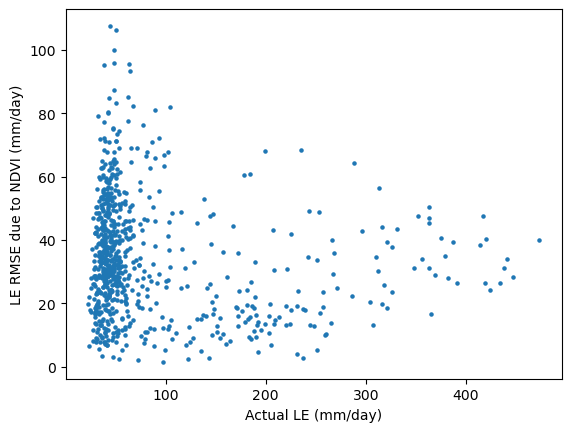

In [ ]:
plt.scatter(x=le_vars, y=np.sqrt(np.array(sd_vars)**2 - np.array(sd_true_vars)**2),s=5)
plt.xlabel("Actual LE (mm/day)")
plt.ylabel("LE RMSE due to NDVI (mm/day)")


In [ ]:
input_variable = ["red", "NIR"]
input_uncertainty = np.array([0.03, 0.03])

## NDVI uncert is conservative estimate from 0.03 err VNIR camera simulations (NIR and Red to NDVI Sensitivity.ipynb)
## Currently uncorrelated uncertainties (could correlated based on empirical correlation of variables)


output_variable = ["LE"]

unperturbed_input, perturbed_input_df, perturbed_output_df, results = joint_perturbed_run(
    input_df=sample_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_verma_PTJPL_table,
    n=100,
    perturbation_mean=np.zeros(2),
    perturbation_cov=np.eye(2) * input_uncertainty ** 2,
    dropna=False
)

kp = (perturbed_input_df.NIR >= 0) & (perturbed_input_df.NIR <= 1) & (perturbed_input_df.red >= 0) & (perturbed_input_df.red <= 1)
ids = results["id"][kp & (perturbed_output_df["LE"] != 0)]

## estimate true LE
repeat_input_df = repeat_rows(sample_df,100)
repeat_input_df = repeat_input_df[kp & (perturbed_output_df["LE"] != 0)]

true_df = process_verma_PTJPL_table(repeat_input_df)
true_df["id"] = ids

perturbed_input_df = perturbed_input_df[kp & (perturbed_output_df["LE"] != 0)]
perturbed_output_df = perturbed_output_df[kp & (perturbed_output_df["LE"] != 0)]

### Process perturbed LE
perturbed_output_df["id"] = ids
perturbed_output_df["LE_perturbation"] = perturbed_output_df["LE"] - true_df["LE"]


0


/Users/Maggiej/Documents/GitHub/ET-Sensitivity/vegetation_conversion/vegetation_conversion.py:45: RuntimeWarning: divide by zero encountered in log
  LAI = rt.clip(-np.log(1 - fIPAR) * (1 / KPAR), min_LAI, max_LAI)


/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_14237/2098577340.py:2: RuntimeWarning: Mean of empty slice
  sd_vars = [np.sqrt(np.nanmean(y.LE_perturbation**2,axis=0)) for y in results_list]
/var/folders/mn/p7nlmtw91vz64gy8rcrtrpgm0000gq/T/ipykernel_14237/2098577340.py:3: RuntimeWarning: Mean of empty slice
  le_vars = [np.nanmean(y.LE,axis=0) for x,y in true_df.groupby('id')]


Text(0, 0.5, 'LE RMSE perturbed NDVI (mm/day)')

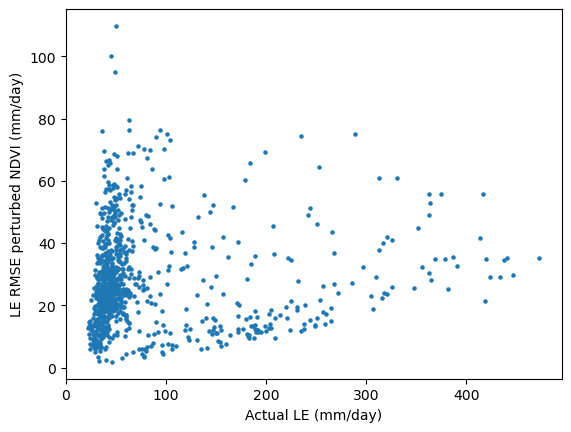

In [ ]:
results_list = [y for x, y in perturbed_output_df.groupby('id')]
sd_vars = [np.sqrt(np.nanmean(y.LE_perturbation**2,axis=0)) for y in results_list]
le_vars = [np.nanmean(y.LE,axis=0) for x,y in true_df.groupby('id')]

plt.scatter(x=le_vars, y=sd_vars,s=5)
plt.xlabel("Actual LE (mm/day)")
plt.ylabel("LE RMSE perturbed NDVI (mm/day)")